## Introduction

This notebook illustrates how we can use NER to search for placenames in a corpus, and enhance a gazetteer. It uses two datesets to illustrate the concepts.

1) [Geograph](https://geograph.org.uk) 
This site invites users to take pictures in the UK and add descriptions. It has almost 7 million pictures, and the data are licenced using a CC By-SA licence, making them available for research as long as we keep the names of the users, and allow others to have access to any data we might create.

2) [Ordnance Survey](https://ordnancesurvey.co.uk/) 50k gazetteer
This gazetteer was published under a UK Open Government licence and contains all place name found on 1:50k maps in the UK. It is a legacy product (i.e. not used or updated any more), but it is suitable for our purposes.

We are going to look for names found in the Geograph data that don't exist in the gazetteer. Since we know that many names occur multiple times, we will do this locally, to increase the chances that we really find new names.

**The first block of our code reads in data and builds a simple spatial index for the gazetteer. We only need to do this once.**

In [5]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results


import os #We import os to stop a weird kernel crash...
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

#Load a language model to do NLP
nlp = spacy.load("en_core_web_md")

In [24]:
#output all dependencies so that we can reproduce the notebook
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas         : 1.2.4
spacy          : 3.0.6
matplotlib     : 3.3.4
OSGridConverter: 0.1.3



In [6]:
#First we read in the geograph data
geograph = pd.read_csv('C:/data/teaching/geo871/code/data/geograph_mini_corpus.csv')
geograph.head()

,id,author,title,text,lon,lat
0,2749148,M J Richardson,Great Blasket Island - 1960,Looking northeast along the northwestern side ...,-10.534101,52.097794
1,635105,Bob Shires,White Beach Great Blasket,The only beach on Great Blasket as seen from t...,-10.514872,52.107609
2,635109,Bob Shires,Remaining homes on Great Blasket,The remaining few habited homes of the abandon...,-10.511764,52.104260
3,259349,Nigel Cox,Coumeenoole Bay,Viewed looking back from the Dunmore Head head...,-10.463579,52.109322
4,16917,Pam Brophy,Clogher Beach,The exact gpr for this beach is Q3153003375. T...,-10.463338,52.157867


In [7]:
#Read in the Ordnance Survey gazetteer
os_50k = pd.read_csv('C:/data/teaching/geo871/code/data/os_50k_gazetteer/data/50kgaz2012.txt',sep=':', encoding='utf8', header=None)
os_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,TQ6004,1066 Country Walk,TQ60,50,49.0,0,16.7,104500,560500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
1,2,TQ7715,1066 Country Walk,TQ60,50,54.7,0,31.5,115500,577500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
2,3,TQ7610,1066 Country Walk Bexhill Link,TQ60,50,52.0,0,30.5,110500,576500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
3,4,TQ8315,1066 Country Walk Hastings Link,TQ80,50,54.5,0,36.6,115500,583500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
4,5,NB5464,A' Beirghe,NB46,58,30.0,6,12.9,964500,154500,W,WI,N Eil,Na h-Eileanan an Iar,X,21-JAN-2003,U,8,0,0


<AxesSubplot:xlabel='x', ylabel='y'>

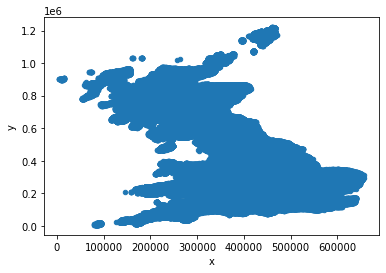

In [8]:
#We need to create locations for each place name in decimal degrees
os_50k[20] = os_50k[4] + os_50k[5]/60
os_50k[21] = os_50k[6] + os_50k[7]/60
os_50k.loc[os_50k[10] == 'W', 21] = -1 * os_50k.loc[os_50k[10] == 'W', 21]

#Tidy up the gazetteer by dropping columns we won't use afterwards
os_trimmed = os_50k.drop([0,1,3,4,5,6,7,10,11,12,14,15,17,18,19], axis = 1)
os_trimmed.head()
os_trimmed.columns = ['name','y','x',
                     'county','type','lat','lon']
os_trimmed.head()

#Plot the gazetteer locations as a sanity check
os_trimmed.plot.scatter(x = 'x', y = 'y')

In [9]:
#We build a simple index using rectangular grid cells
#Each cell contains all placenames from the gazetteer for that cell and can be used to do a lookup
#cellSize determines the resolution in metres

cellSize = 10000
minx = os_trimmed['x'].min()
maxx = os_trimmed['x'].max()
miny = os_trimmed['y'].min()
maxy = os_trimmed['y'].max()

w = maxx - minx
h = maxy - miny

nc = int(w/cellSize) + 1
nr = int(h/cellSize) + 1

gaz = pd.DataFrame(index=range(nc),columns=range(nr))

In [10]:
#Now we populate the index with names
for index, row in os_trimmed.iterrows():
    i = int((row['x'] - minx)/cellSize)
    j = int((row['y'] - minx)/cellSize)
    name = row['name']
    
    if pd.isnull(gaz.at[i,j]):
        gaz.at[i,j] = {name}
    else:
        names = gaz.at[i,j]
        names.add(name)
        gaz.at[i,j] = names

In [11]:
#Example output for a single cell - returns nan if no names present
gaz.at[20,20]

{'Atheston',
 'Barre',
 'Begelly',
 "Bishop's Br",
 'Black Moor',
 'Blackaldern',
 'Blackpool',
 'Blaencilgoed Fm',
 'Blaengwaithnoah',
 'Bluestone',
 'Brince',
 'Broadmoor',
 'Broom',
 'Bryn Hill',
 'Camp Hill',
 'Campshill Fm',
 'Canaston',
 'Canaston Wood',
 'Captain Style',
 'Carew Mountain',
 'Carne',
 'Castell Coch',
 'Catershook',
 'Chapel Hill',
 'Churchton',
 'Cilrhiw Ho',
 'Cloverhill Fm',
 'Cold Blow',
 'Cold Inn',
 'Coppet Hall Pt',
 'Cott Fm',
 'Cowsland',
 'Cresselly',
 'Cresselly Big Wood',
 'Cresswell Quay',
 'Crinow',
 'Cross Hands',
 'Dawes Fm',
 'Dinaston',
 'Dyffryn Fm',
 'Eweton',
 'Flimston',
 'Folly Fm',
 'Freestone Hall',
 'Gloyne Fm',
 'Glyn Patel',
 'Great Molleston Fm',
 'Grove, The',
 'Hackett',
 'Hean Cas',
 'High Toch',
 'Highgate',
 'Hill',
 'Holy Well',
 'Honeys Croft',
 'Jeffreyston',
 'Kilgetty',
 'Kilgetty Fm',
 "King's Moor",
 'Knaps',
 'Lanesend',
 'Langdon',
 'Llan-mill',
 'Longstone',
 'Longstone, The',
 'Loveston',
 'Ludchurch',
 'Martin Hill',
 

This block is just to show the NLP results for a single document

In [12]:
#First we demonstrate how the NLP works for a single example document
doc = nlp(geograph.text[20])
spacy.displacy.render(doc, style="ent")
doc_nouns = list(doc.noun_chunks)
print("nouns:",doc_nouns)
for ent in doc.ents:
      print("NER:", ent.text, ent.label_)
          

nouns: [Ballyferriter, the north eastern section, the grid square, the R559 (Dingle Way, a view, the southern end, the town]
NER: Ballyferriter PERSON
NER: R559 PRODUCT
NER: Dingle Way PERSON


The code from here on does the matching. Since we **draw a random sample of documents** from the Geograph data every time, the **results will also vary**. Rerun the code to see how the proportion of names found and their types vary.

In [13]:
#Now I am going to load a random sample of m Geograph documents
m= 200
sample = geograph.sample(n = m)
docs = list(nlp.pipe(sample.text,n_process=2, batch_size=100))

#Now we store the NER results with the original geograph document ids, text and coordinates
results = list()
for (idxRow, s1), (_, s2) in zip(sample.iterrows(), enumerate(docs)):
    try:
        g = OSGridConverter.latlong2grid (s1.lat, s1.lon, tag = 'WGS84')
        dict = {
            "id": s1.id,
            "x": g.E,
            "y": g.N,
            "entities": s2.ents,
            "text": s1.text   
        }
        results.append(dict)
    except ValueError:
        print("Problem with a document", s1.text)
        #Ignore documents we couldn't parse for some reason

Problem with a document 0
Problem with a document 0
Problem with a document 0


In [14]:
#Show the results - these are essentially all the NER tokens found in each document
for dict in results:
    print(dict.get("id"), dict.get("x"), dict.get("y"), dict.get("entities"))

2076220 344780 663930 ()
274003 483699 384900 (Knaith Hill,)
2749883 352349 269330 ()
643647 352600 608420 (Hawick,)
3041418 442149 238430 (Broughton,)
1034735 402499 202020 ()
845551 137407 496497 (the Dromara Hills,)
2461655 332209 741730 (Newtyle village,)
2227368 505940 120490 (Codmore Hill,)
73221 570500 264500 (Moulton, Primrose Hill Farm, Moulton)
103315 367099 675200 (Spott Farm,)
2923340 88070 11980 (The South Hill, Sampson)
2390444 493479 98780 (Bognor Regis,)
2809917 479799 134780 ()
1325078 459820 183660 (South Stoke,)
1707350 122656 491389 (Shinn Road, Shinn Road)
2328270 401419 289380 (Smethwick Galton Bridge, Worcester, Birmingham, Kidderminster, Birmingham, Wolverhampton, Shirley, Birmingham, Snow Hill)
1245127 317549 360120 (Fron Hen,)
2285477 410209 578710 (Grade II, 28 April 1969 dated 1830, Charles Monck, A696 Belsay, Northumberland)
899446 333500 630500 (Black Rig, Minch Moor)
168623 484899 260600 ()
3139189 448579 388240 (Brampton Road,)
2008493 255200 47780 (Stok

In [15]:
#Now we are going to compare the gazetteer names with those we found

data = list()
#We iterate through all our results
for dict in results:
    #First we get the cell indices for the gazetteer
    x = dict.get("x")
    y = dict.get("y")
    i = int((x - minx)/cellSize)
    j = int((y - minx)/cellSize)
    try:
        #Now we find the names in that cell - n.B. we ignore for now the fact that Geograph cell could be at a boundary
        gazNames = gaz.at[i,j]
        #Deal with a cell having no values in the gazetteer
        if (isinstance(gazNames,set) == False): 
            #print(type(gazNames))
            gazNames = {"NoNamesFound"}
    except KeyError:
        gazNames = {"NoNamesFound"}
    #Get back the named entities for the text        
    ents = dict.get("entities")
    #Now we iterate through, and find out if each name is already in the local gazetteer
    for ent in ents:        
        if (ent.text in gazNames):
            data.append([dict.get("id"), "Existing", ent.text, ent.label_, x, y]) 
            #print("Found existing name:", ent.text, ent.label_)
        else:
            #print("Potential new name:" , ent.text, ent.label_)
            data.append([dict.get("id"), "New", ent.text, ent.label_, x, y]) 
#Store the results in a dataframe
df = pd.DataFrame(data, columns = ['id', 'status','name','type','x','y'])
df

,id,status,name,type,x,y
0,274003,New,Knaith Hill,FAC,483699,384900
1,643647,New,Hawick,PERSON,352600,608420
2,3041418,Existing,Broughton,PERSON,442149,238430
3,845551,New,the Dromara Hills,LOC,137407,496497
4,2461655,New,Newtyle village,GPE,332209,741730
...,...,...,...,...,...,...
320,748523,New,the Grantham Canal,LOC,462969,336470
321,748523,Existing,Cotgrave,GPE,462969,336470
322,748523,New,Hllygate Bridge,FAC,462969,336470
323,748523,New,SK6535]].The,ORG,462969,336470


In [16]:
#Split results into existing and candidate names for reporting
new = df.loc[df['status'] == 'New']
existing = df.loc[df['status'] == 'Existing']

Text(0.5, 1.0, 'Counts for existing names')

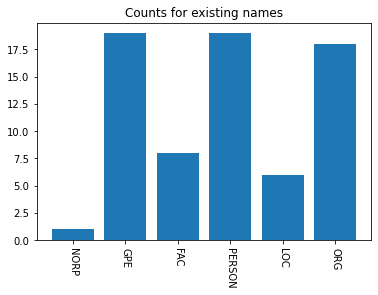

In [17]:
#Create a bar plot of existing names
count = list()
values = list()
for value in set(existing['type']):
    count.append(list(existing['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for existing names')

Text(0.5, 1.0, 'Counts for candidate new names')

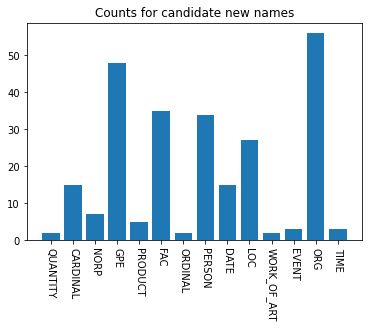

In [18]:
#Create a bar plot of new names
count = list()
values = list()
for value in set(new['type']):
    count.append(list(new['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for candidate new names')

In [19]:
#Let's look at one example NER class in the candidate names
names = existing.loc[existing['type'] == 'GPE']

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(names)

          id    status            name type       x        y
13   1325078  Existing     South Stoke  GPE  459820   183660
38   1155033  Existing    Lowbury Hill  GPE  451220   182800
40   1976950  Existing   Gravelly Hill  GPE  533617   152883
55    889102  Existing        Kennford  GPE  291500    86500
58   1366603  Existing       Lipe Hill  GPE  318509   121090
60   2510711  Existing      Stake Hill  GPE  393909   523790
65   2780869  Existing      Chiddingly  GPE  554239   114350
70   2435570  Existing      Herne Hill  GPE  531929   174370
76    888341  Existing     Broomy Hill  GPE  348370   238300
87   3065834  Existing  Wetwang Grange  GPE  494449   460730
92   3317040  Existing          Meifod  GPE  285849   376510
101  2008540  Existing         Banbury  GPE  445719   240700
104  2921397  Existing          Hexham  GPE  393999   563590
126   370404  Existing       Uyeasound  GPE  460599  1200660
132   269587  Existing    Hadyard Hill  GPE  225600   596000
147  1189080  Existing  

In [22]:
cn = len(set(new['name']))
ce = len(set(existing['name']))
print("Found ", ce, " unique existing names and ", cn, " unique new names.")

Found  67  unique existing names and  240  unique new names.
